In [8]:
import os
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from math import pi



rcParams['figure.dpi'] = 500
rcParams['savefig.dpi'] = 500
rcParams['font.family'] = 'Arial'
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 18
rcParams['legend.fontsize'] = 18
rcParams['figure.titlesize'] = 18
rcParams['markers.fillstyle'] = 'none'


# Used in the yield_data function
problem_nphard_mapper = {
    'SPP': 'p', 'MFP': 'p', 'BSP': 'p', 'EDP': 'p',
    'TSP_D': 'np-cmp', 'GCP_D': 'np-cmp', 'KSP': 'np-cmp',
    'TSP': 'np-hard', 'GCP': 'np-hard', 'MSP': 'np-hard',
}

nphard_order_mapper = {'np-hard': 2, 'np-cmp': 1, 'p': 0}


# change BSP to SAS
problem_order_mapper = {
    'GCP': 0, 'TSP': 1, 'MSP': 2, 'GCP_D': 3, 'TSP_D': 4, 'KSP': 5, 'SAS': 6, 'EDP': 7, 'SPP': 8
}


model_order_mapper = {"GPT 4 Turbo": 0, "GPT 3.5 Turbo": 1, "Claude 2":2, "Claude instant":3 ,"PaLM 2": 4, 
                       "MPT-30b":5 ,"Mistral-7b": 6, "Phi-1.5": 7, "Phi-2": 8,"Qwen-14b": 9,"Vicuna-13b": 10,"Yi-34b": 11,
                       "Close models":12, "Open models" : 13, "All models":14}



def yield_data(data):
    """Generate the data for the detailed dataframe"""
    model_name = data["model_name"]
    problem_name = data["problem_name"]
    model_type = data["model_type"]
    prompt_type = data["prompt_type"]

    ##########################################################
    # debug code

    try:
        problem_nphard_mapper[problem_name]
    except:
        print('in yield_data except')
        print(data)
        print()
        
    return [
        {
            "model_name": model_name,
            "problem_name": problem_name,
            "problem_type": problem_nphard_mapper[problem_name],
            "model_type": int(model_type == "Close"),
            "prompt_type": prompt_type,
            "recognized": data["recognized"][i],
            "parsable": data["parsable"][i],
            "correctness": data["correctness"][i],
            "recognized_and_parsable": data["recognized_and_parsable"][i],
            "level": data["level"][i]
        } for i in range(10) 
    ]

In [9]:
class ResultsInfo:
    """Wrapper class for the dataset"""
    def __init__(self, DATA_PATH, model_types, prompt_types, level_range, save_path=None):
        """initizalize the dataset"""
        assert os.path.exists(DATA_PATH), f"{DATA_PATH} does not exist"
        self.main_dir = DATA_PATH
        self.model_type_dirs = []
        self.prompt_type_dirs = []
        self.data = []
        self.level_range = level_range
        self.fetch_model_types(model_types)
        self.fetch_prompt_types(prompt_types)
        self.fetch_exist_results()
        self.dataframe = None
        self.convert_to_dataframe()
        self.rename_model_prompt_type()
        # save the dataframe
        if save_path:
            self.dataframe.to_csv(save_path, index=False)

    def fetch_model_types(self, model_types):
        """Fetch the existing model type directories"""
        for model_type in model_types:
            datapath = os.path.join(self.main_dir, model_type)
            if os.path.exists(datapath):
                self.model_type_dirs.append(model_type)
    
    def fetch_prompt_types(self, prompt_types):
        """For each model type, fetch the existing prompt type directories"""
        for model_type_dir in self.model_type_dirs:
            for prompt_type in prompt_types:
                datapath = os.path.join(self.main_dir, model_type_dir, prompt_type)
                if os.path.exists(datapath):
                    self.prompt_type_dirs.append((model_type_dir, prompt_type))
    
    def fetch_exist_results(self):
        """Iterate through the directories and fetch the json results and metadata"""
        for model_type, prompt_type in tqdm(self.prompt_type_dirs):
            datapath = os.path.join(self.main_dir, model_type, prompt_type)
            for file in os.listdir(datapath):
                if file.endswith(".json"):
                    self.fetch_json_result(file, model_type, prompt_type, datapath)
    
    def fetch_json_result(self, file, model_type, prompt_type, datapath):
        """Fetch the result and extract the metadata from one json file"""
        metadata = self.parse_json_filename(file)
        metadata.update({"model_type": model_type, "prompt_type": prompt_type})
        # data = []
        data = None
        try:
            with open(os.path.join(datapath, file), "r") as f:
                # old way of load data
                data = json.load(f)

            if prompt_type == "recognition":
                data_info = self.recognition_data_info_extractor(data, metadata)
            else:
                data_info = self.data_info_extractor(data, metadata)
            data_info.update(metadata)
            self.data.append(data_info)
        except Exception as e:
            print(f"Error in fetching {file}: {e}")
            print(f"metadata: {metadata}")
            print()
            pass

    def parse_json_filename(self, filename):
        """Parse the filename to extract the model and problem names to get the metadata"""

        first_split = filename.split('_', 1)

        # Extract the model name as the first part
        model_name = first_split[0]
        if model_name == "BSP":
            model_name = "SAS"

        # Remove the file extension and the word "Results"
        test_name_with_suffix = first_split[1].rsplit('Results', 1)[0]
        if test_name_with_suffix[-1] == '_':
            test_name_with_suffix = test_name_with_suffix[:-1]
        test_name_with_suffix = test_name_with_suffix.upper()

        return {"model_name": model_name, "problem_name": test_name_with_suffix}

    def data_postprocessor(self, data, metadata):
        """
        Postprocess the data to extract the required information because the data is 
        not in the same format
        """
        standard_data = []
        for x in data:

            # since the Gemini output include an extra dict
            # a navie approch is used to skip such dict 
            if "id" and "object" in x:
                continue   


            # edit due to missing correctness key
            if "correctness" not in x:
                x["recognized"] = False
                x["correctness"] = False
            else:
                x["recognized"] = x["correctness"] is not None
                x["correctness"] = x["correctness"][0] if isinstance(x["correctness"], list) else x["correctness"]

            # x["recognized"] = x["correctness"] is not None
            # x["correctness"] = x["correctness"][0] if isinstance(x["correctness"], list) else x["correctness"]

            # edit parsable if needed 
            x["parsable"] = (x["output"] != "")

            # a naive attempt
            # x["parsable"] = (x["output"] != "")
            # if x["parsable"]:
            #     # check for invalid string in x["correctness"] attribute
            #     if isinstance(x["correctness"], list) and len(x["correctness"]) == 2: 
            #     # example see BSP_blip2_results.json
            #         if "invalid" in x["correctness"][1]:
            #             x["parsable"] = False
            #         # example see EDP_llava_results.json
            #         elif "No solution" in x["correctness"][1]:
            #             x["parsable"] = False

            #     else:
                        # pass
            #         # by observation of some GCP result  


            standard_data.append(x)
        return standard_data

    def recognition_data_info_extractor(self, data, metadata):
        recognized_summary = np.array([x["mean"] for x in data]).reshape(-1, 10).sum(axis=-1)
        return {
            "recognized": recognized_summary,
            "parsable": recognized_summary,
            "correctness": recognized_summary,
            "recognized_and_parsable": recognized_summary,
            "level": self.level_range
        }

    def data_info_extractor(self, data, metadata):
        """
        For each data and metadata, extract the required information from the data
        """
        standard_data = self.data_postprocessor(data, metadata)
        data_summary = self.data_summary(standard_data)
        return data_summary
    
    def data_summary(self, data):
        """Summarize the data"""
        recognized_data = np.array([x["recognized"] for x in data]).reshape(-1, 10)
        parsable_data = np.array([x["parsable"] for x in data]).reshape(-1, 10)
        correctness_data = np.array([x["correctness"] for x in data]).reshape(-1, 10)

        recognaized_summary = np.sum(recognized_data, axis=-1)
        failure_summary = np.sum(parsable_data, axis=-1)
        number_of_recognized_and_parsable = np.sum(recognized_data * parsable_data, axis=-1)
        correctness_summary = np.sum(correctness_data, axis=-1)
        return {
            "recognized": recognaized_summary,
            "parsable": failure_summary,
            "correctness": correctness_summary,
            "recognized_and_parsable": number_of_recognized_and_parsable,
            "level": self.level_range
        }

    def convert_to_dataframe(self):
        """Convert the data to a pandas dataframe"""
        # old code
        # all_data = [a for x in self.data for a in yield_data(x)]
        # self.dataframe = pd.DataFrame(all_data)

        ###########################################################
        # debug code
        try:
            all_data = [a for x in self.data for a in yield_data(x)]
            self.dataframe = pd.DataFrame(all_data)
        except Exception as e:
            print("error in convert_to_dataframe")
            print(f"e is  {e}")
            print("all data:")
            print(self.data)
            raise e


    
    def rename_model_prompt_type(self):
        model_replace_dict = {
            "mpt": "MPT-30b",
            "mistral": "Mistral-7b",
            "phi": "Phi-1.5",
            "phi-2": "Phi-2",
            "qwen": "Qwen-14b",  
            "vicuna": "Vicuna-13b",
            "yi": "Yi-34b", 
            "claude-2": "Claude 2",
            "claude-instant-1.2": "Claude instant",
            "gpt-3.5-turbo": "GPT 3.5 Turbo",
            "gpt-4-1106-preview": "GPT 4 Turbo",
            "chat-bison@001": "PaLM 2",
        }

        self.dataframe["model_name"] = self.dataframe["model_name"].replace(model_replace_dict)


In [10]:
class SummarizeHelper:
    """Helper class to summarize the data to prepare for the visualization"""
    def __init__(self, dataframe, summary_func):
        self.dataframe = dataframe
        self.summary_func = summary_func
    
    # add summary_columns = None
    def summarize(self, summary_columns= None, groupby_columns=None, pre_func=None, post_func=None):
        # TO-DO: to be refined
        dataframe = self.dataframe.copy()
        if pre_func:
            dataframe = pre_func(dataframe)
        if groupby_columns:
            column_used = groupby_columns + summary_columns
            dataframe = dataframe[column_used].groupby(groupby_columns, as_index=False).agg({
                col: self.summary_func[col] for col in summary_columns
            }).reset_index()
        if post_func:
            dataframe = post_func(dataframe)
        return dataframe


def pre_func_for_agg_acc(dataframe):
    dataframe_prompt = dataframe[dataframe["prompt_type"] != "recognition"].copy()
  
    # Obtain the Acc
    dataframe_prompt["AA"] = dataframe_prompt["correctness"] / dataframe_prompt["recognized_and_parsable"].clip(0.1, 10)
    dataframe_prompt["FR"] = 1 - dataframe_prompt["parsable"] / 10
    dataframe_prompt["Acc"] = dataframe_prompt["AA"] * (1 - dataframe_prompt["FR"])
    # Obtain the weighted_acc
    # the RA data is derived from the recognition data set
    dataframe_prompt["RA"] = 1

    dataframe_prompt["weighted_acc"] = dataframe_prompt["Acc"] * dataframe_prompt["RA"]
    return dataframe_prompt



# apply weight of level 
def pre_func_common(data):
    dataframe = data.copy()
    dataframe["weighted_acc"] = dataframe["weighted_acc"] * dataframe["level"]
    return dataframe

# the weight of a level is apply using the mean form
def post_func_common(data):
    data["weighted_acc"] = data["weighted_acc"] / data["level"]
    return data

In [11]:
class DrawHelper:
    """Helper class to draw the results from the dataframe"""
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def plot_bar_chart(self, x_name, y_name, hue_name):
        sns.barplot(data=self.dataframe, x=x_name, y=y_name, hue=hue_name)
        plt.title("Weighted accuracy in different prompt types")
        plt.ylabel("Weighted accuracy")
        plt.xlabel("Model name")

    def plot_heatmap_recognition(self):
        col = ["model_name",'problem_name',"RA"]
        self.dataframe = self.dataframe[col]
        pivot_table = self.dataframe.pivot(index='model_name', columns='problem_name', values='RA')
        question_order = ['GCP', 'TSP', 'MSP', 'GCP_D', 'TSP_D', 'KSP', 'SAS', 'EDP', 'SPP']
        pivot_table = pivot_table[question_order]
        pivot_table = pivot_table.sort_index(key=lambda x: x.map(model_order_mapper))
        sns.heatmap(pivot_table, annot=True, vmin=0, vmax=1, cmap='Blues', fmt='.2f')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.tight_layout()
    
    def plot_heatmap(self, x_name, y_name, z_name, col_name, problem_order_mapper):
        for z in self.dataframe[z_name].unique():
            tmp_df = self.dataframe[self.dataframe[z_name] == z].copy()

            # reorder level and model name  
            tmp_df = tmp_df.pivot_table(index=x_name, columns=y_name, values=col_name, aggfunc='mean').fillna(0).reset_index()

            # apply transpose() to set x be the level y be the model name
            col = list(tmp_df["level"])
            tmp_df = tmp_df.transpose()
            tmp_df = tmp_df.drop('level')
            tmp_df.columns = col
            tmp_df = tmp_df.sort_index(key=lambda x: x.map(model_order_mapper))

            pos = problem_order_mapper[z] + 1
            plt.subplot(3, 3, pos)
            sns.heatmap(tmp_df, annot=True, vmin=0, vmax=1, cmap='Blues', fmt='.2f', cbar=False)
            # could be removed since the naming is changed after create base summary
            plt.title(z.upper())
            plt.xlabel(None)
            plt.ylabel(None)
            plt.tight_layout()

            
    def plot_spider(self, *metrics):
        dataframe = self.dataframe.copy()
        my_dpi = 100
        fig = plt.figure(figsize=(3000/my_dpi, 3000/my_dpi), dpi=my_dpi)
        
        cols = 3
        rows = 3
        
        gs = gridspec.GridSpec(rows, cols, wspace=0.5, hspace=0.5)
        
        for i, (index, row_data) in enumerate(dataframe.iterrows()):
            if i >= rows * cols:  
                break
            ax = plt.subplot(gs[i], polar=True)  # Specify polar=True here
            self.plot_sub_spider(row_data, ax, *metrics)


    def plot_sub_spider(self, row_data, ax, *metrics):

        # here we assue five metrics 
        angles = [n / float(5) * 2 * pi for n in range(5)]
        offset = pi / 5  
        angles = [(angle + offset) % (2 * pi) for angle in angles]  

        angles += angles[:1]
        
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        
        metrics = list(metrics)
        metrics_tag = metrics.copy()
        for i in range(len(metrics_tag)):
            if metrics_tag[i] == 'AA NP Hard':
                metrics_tag[i] = 'AA \n NP Hard'
            if metrics_tag[i] == 'AA P':
                metrics_tag[i] = 'AA \nP'
            if metrics_tag[i] == 'AA NP Complete':
                metrics_tag[i] = 'AA \n NP Complete'
        
        plt.xticks(angles[:-1], metrics_tag, color='black', size=20)
        ax.tick_params(axis='x', pad=30)
        
        ax.set_rlabel_position(0)
        plt.yticks([0,0.25,0.5,0.75,1], ['0','0.25','0.5','0.75','1'], color="grey", size=18)
        plt.ylim(0,1)
        
        model_name = row_data['model_name']
        row_values = [row_data[metric] for metric in metrics]
        row_values += row_values[:1]
        
        ax.plot(angles, row_values, linewidth=2, linestyle='solid')
        ax.fill(angles, row_values, alpha=0.2)
        
        ax.set_title(model_name, size=35, y=1.1)  # Correctly set the title for the subplot
        


def gather_final_summary(base_info, cl_info, p_acc_info, npc_acc_info, nph_acc_info):
    base_info = base_info.copy()
    for i, row in base_info.iterrows():
        model_name = row["model_name"]
        cl = cl_info[cl_info["model_name"] == model_name]["cl"].values[0]
        p_acc = p_acc_info[p_acc_info["model_name"] == model_name]["weighted_acc"].values[0]
        npc_acc = npc_acc_info[npc_acc_info["model_name"] == model_name]["weighted_acc"].values[0]
        nph_acc = nph_acc_info[nph_acc_info["model_name"] == model_name]["weighted_acc"].values[0]
        base_info.loc[i, "cl"] = cl
        base_info.loc[i, "p_acc"] = p_acc
        base_info.loc[i, "npc_acc"] = npc_acc
        base_info.loc[i, "nph_acc"] = nph_acc
    return base_info

In [23]:
def plot_line_chart(self, col_name, x_name, x_order_mapper,ax):
        tmp_df = self.dataframe.copy()
        tmp_df['x_order'] = tmp_df[x_name].map(x_order_mapper)
        tmp_df.sort_values(by=['x_order', 'model_type'], inplace=True)

        open_model_df = tmp_df[tmp_df['model_type'] == 0]
        close_model_df = tmp_df[tmp_df['model_type'] == 1]

        number_of_close_models = close_model_df['model_name'].nunique()
        number_of_open_models = open_model_df['model_name'].nunique()

        # make one red palette and one blue palette
        palette = sns.color_palette('tab20', n_colors=number_of_close_models + number_of_open_models)
        palette = sorted(palette, key=lambda x: x[0] - x[2])
        palette_map = {}

        sns.pointplot(data=open_model_df, ax = ax, x=x_name,
                y=col_name, hue='model_name', linestyle='',
                alpha=0.8, marker='s', palette=palette[:number_of_open_models])
        palette_map = {model: palette[i] for i, model in enumerate(open_model_df['model_name'].unique())}

        sns.pointplot(data=close_model_df, ax = ax, x=x_name, y=col_name,
                        hue='model_name', linestyle='', alpha=0.8, marker='^', palette=palette[number_of_open_models:])
        palette_map.update({model: palette[i + number_of_open_models] for i, model in enumerate(close_model_df['model_name'].unique())})

        sns.lineplot(data=close_model_df, ax = ax, x=x_name, y=col_name, color='darkred',
                        marker='o', markersize=10, fillstyle='full', label='Close models', errorbar=None)
        
        sns.lineplot(data=open_model_df, ax = ax, x=x_name, y=col_name, color='red',
                        marker='o', markersize=10, fillstyle='full', label='Open models', errorbar=None)

        sns.lineplot(data=tmp_df, ax = ax, x=x_name, y=col_name, color='black',
                        marker='o', markersize=10, fillstyle='full', label='All models', errorbar=None)
        
        leg = ax.legend()

        if col_name == 'weighted_acc':
            plt.title("a.", loc='left')
            plt.ylabel('Aggregate Accuracy')
            # for text in plt.legend().get_texts():
            #     text.set_fontsize('xx-small') 
            # edit markerscale and fontsize to small to accommodate the graph
            leg.remove()

            
        else:
            plt.title("b.", loc='left')
            plt.ylabel('Instruction Following \n Effective Rate')
            # get the label and name and sort them based on model_order_mapper
            handles, labels = plt.gca().get_legend_handles_labels()
            sorted_labels_handles = sorted(zip(labels, handles), key=lambda lh: model_order_mapper.get(lh[0], 0))
            sorted_labels, sorted_handles = zip(*sorted_labels_handles)
            ax.legend(sorted_handles, sorted_labels,title='Model',bbox_to_anchor=(1.05, 1),\
                         markerscale=1.3, fontsize='large',loc='upper left',title_fontsize = 'x-large')


        ax.set_ylim([0, 1])
        plt.xlabel('Complexity')
        # plt.tight_layout()
        ax.set_xticklabels(['P','NP-Complete','NP-Hard'])
        plt.ylim(0, 1.05)



DrawHelper.plot_line_chart = plot_line_chart

In [13]:
DATA_PATH = "Results"
model_types = ["Open", "Close"]
prompt_types = ["figure+full_text", "figure+limited_text", "full_text_only", "recognition"]
level_range = np.arange(1, 11)
data = ResultsInfo(DATA_PATH, model_types, prompt_types, level_range, save_path="results.csv")
data.dataframe['problem_name'] = data.dataframe['problem_name'].replace('BSP', 'SAS')


# assume that for each groupby, it has the same number of results. Otherwise, it will be problematic
# the raw weighted_acc does not apply the level weight
summary_func = {"level": "mean", "FR": "mean", "RA": "mean", "weighted_acc": "mean"}
baseSummary = SummarizeHelper(data.dataframe, summary_func)

base_summary_info = baseSummary.summarize(pre_func=pre_func_for_agg_acc)
base_summary_info["effective_rate"] = 1 - base_summary_info["FR"]
base_summary_info.to_csv("base_summary_info.csv", index=False)

summary1 = SummarizeHelper(base_summary_info, summary_func)
summary_info1 = summary1.summarize(
    groupby_columns=["model_name", "problem_name", "problem_type"],
    summary_columns=["RA", "FR", "weighted_acc", "level"],
    pre_func=pre_func_common,
    post_func=post_func_common
).sort_values(by="model_name", key=lambda x: x.map(model_order_mapper))
summary_info1["effective_rate"] = 1 - summary_info1["FR"]
summary_info1.to_csv("summary_info1.csv", index=False)

summary_info2 = summary1.summarize(
    groupby_columns=["prompt_type", "model_name"],
    summary_columns=["RA", "FR", "weighted_acc", "level"],
    pre_func=pre_func_common,
    post_func=post_func_common
).sort_values(by="model_name", key=lambda x: x.map(model_order_mapper))
summary_info2["effective_rate"] = 1 - summary_info2["FR"]
summary_info2.to_csv("summary_info2.csv", index=False)

summary_info3 = summary1.summarize(
    groupby_columns=["model_name", "problem_type", "model_type"],
    summary_columns=["RA", "FR", "weighted_acc", "level"],
    pre_func=pre_func_common,
    post_func=post_func_common
).sort_values(by="model_name", key=lambda x: x.map(model_order_mapper))
summary_info3["effective_rate"] = 1 - summary_info3["FR"]
summary_info3.to_csv("summary_info3.csv", index=False)

100%|██████████| 2/2 [00:00<00:00, 31.91it/s]


In [7]:
# create folder
folder_name = "figures"
current_directory = os.getcwd()
folder_path = os.path.join(current_directory, folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_name}' created.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'figures' already exists.


C:\Users\010\AppData\Local\Temp\ipykernel_15656\1841340711.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\010\AppData\Local\Temp\ipykernel_15656\314662530.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['P','NP-Complete','NP-Hard'])
C:\Users\010\AppData\Local\Temp\ipykernel_15656\314662530.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['P','NP-Complete','NP-Hard'])


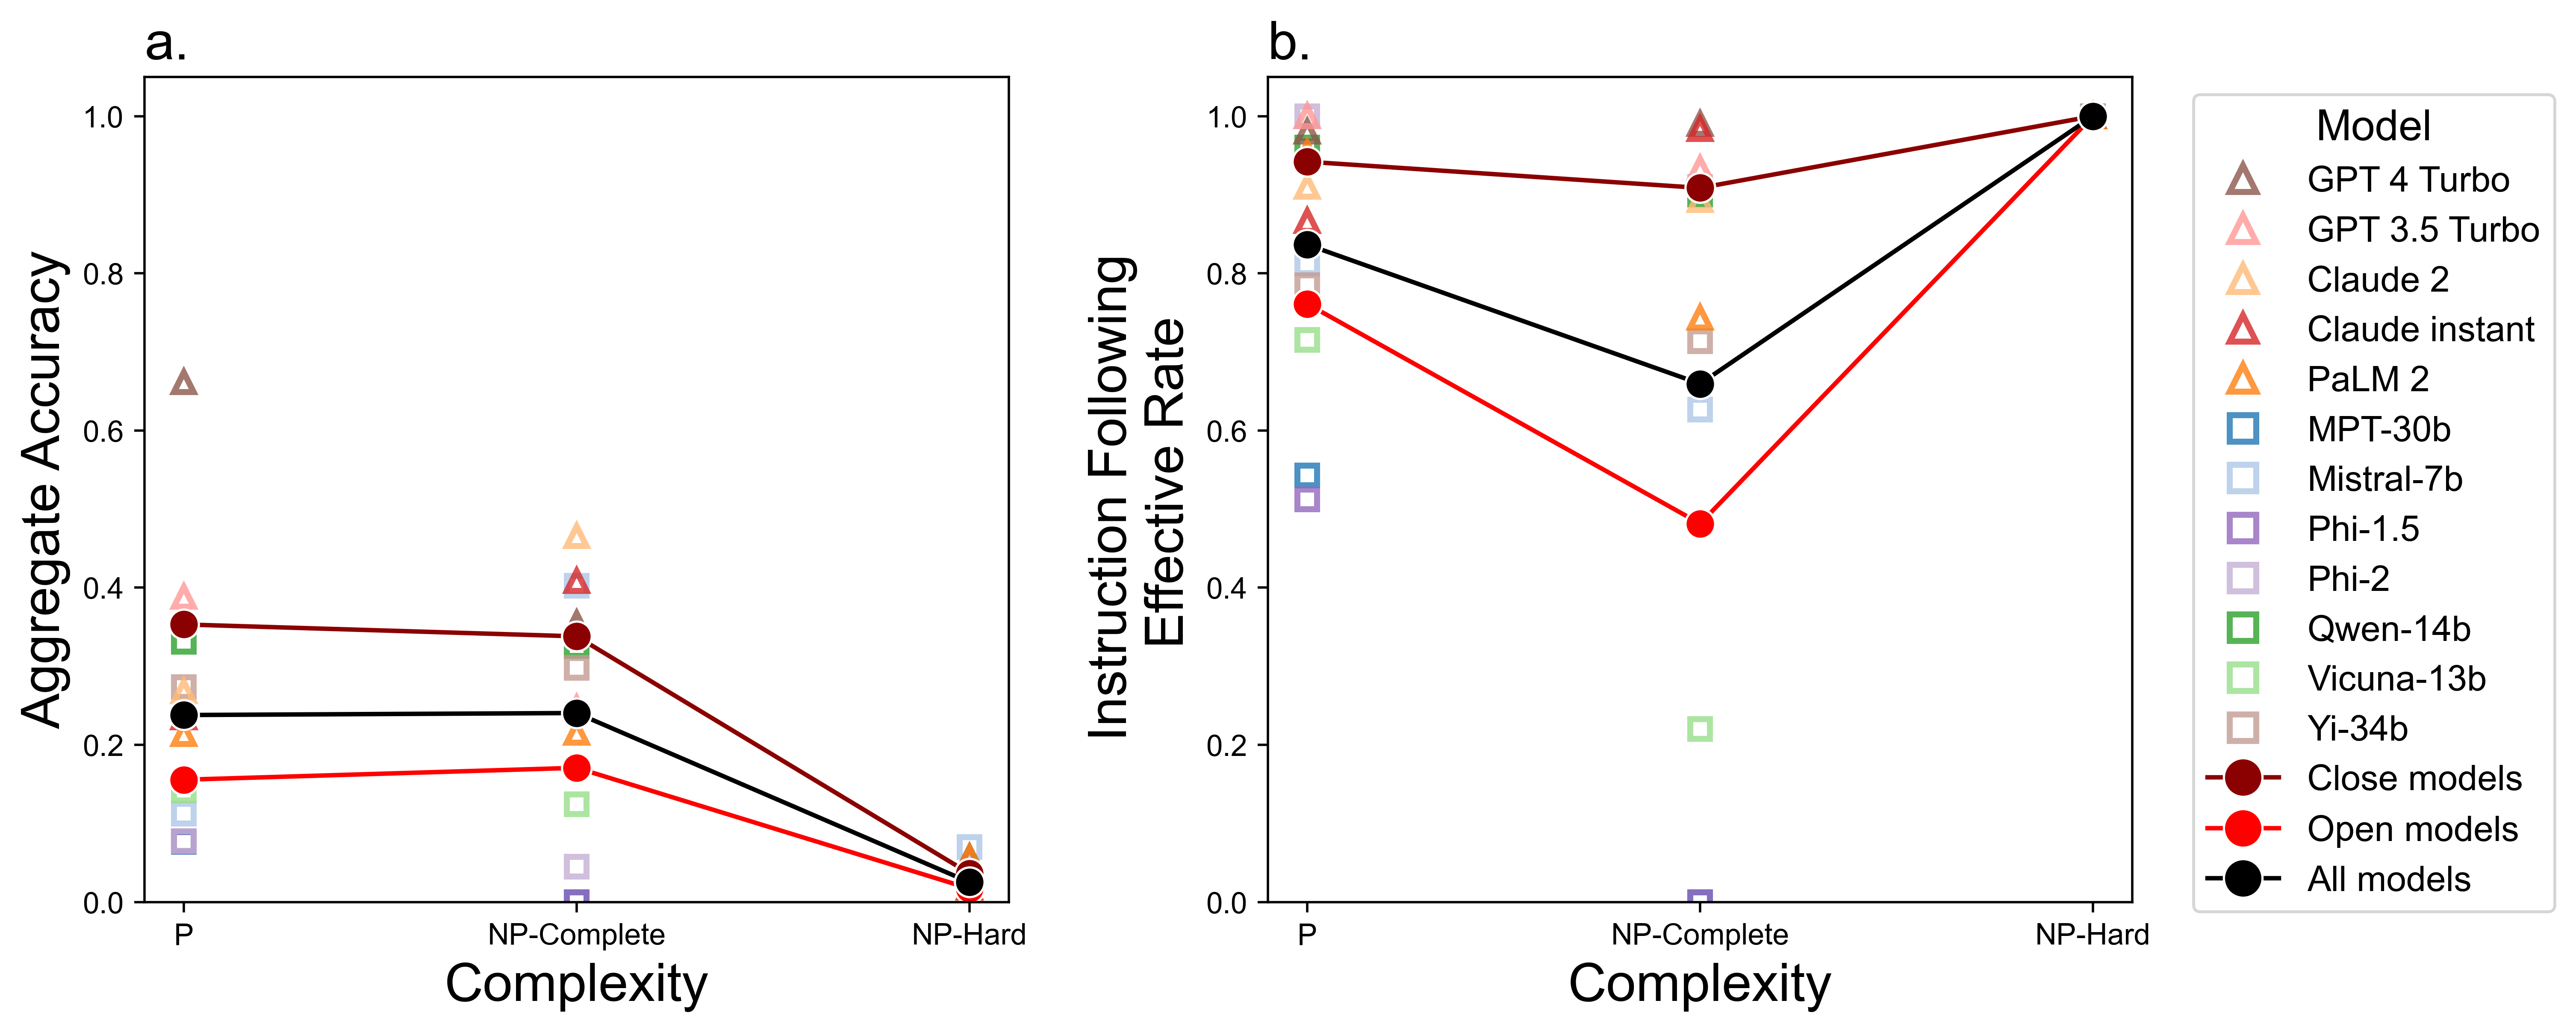

In [24]:
# rq1
rq1_drawer = DrawHelper(summary_info3)
## rq1.1
fig, axs = plt.subplots(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1],wspace=0.30)

ax1 = plt.subplot(gs[0, 0])
rq1_drawer.plot_line_chart('weighted_acc', 'problem_type', nphard_order_mapper,ax1)
ax1.set_aspect(2)

ax2 = plt.subplot(gs[0, 1])
rq1_drawer.plot_line_chart('effective_rate', 'problem_type', nphard_order_mapper,ax2)
ax2.set_aspect(2)

plt.savefig('figures/weighted_accuracy_effective_rate.png', bbox_inches='tight')